## **External Libriaries and modules for work with data and model**

In [1]:
import pandas as pd
import numpy as np
import requests
import warnings
import nltk
import math
import time
import re
import os
import plotly
import plotly.figure_factory as ff
import pandas_profiling as pp

from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from matplotlib import gridspec
from scipy.sparse import hstack
from plotly.graph_objects import Scatter, Layout

plotly.offline.init_notebook_mode(connected = True)
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use(style = 'tableau-colorblind10')
plt.rcParams['figure.figsize'] = (15, 10)
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Script to read csv file into Google Collaboratory

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentication and creation of the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive()

In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
train = pd.read_csv(BytesIO(uploaded['train.csv']))
test = pd.read_csv(BytesIO(uploaded['test.csv']))
submission_example = pd.read_csv(BytesIO(uploaded['sample_submission.csv']))

## **Data Exploration and EDA**

In [5]:
print('Train shape: {}'.format(train.shape))
print('Test shape: {}'.format(test.shape))
print('Submission shape {}'.format(submission_example.shape))

Train shape: (1460, 81)
Test shape: (1459, 80)
Submission shape (1459, 2)


In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
# Checking for overall null or NaN values in train DataFrame
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [9]:
# Check the target variable statistics
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [10]:
train['SalePrice'].skew()

1.8828757597682129

In [0]:
# Because of right-skewness, use log-transformation of the data
train['LT_SalePrice'] = np.log(train['SalePrice'] + 1)

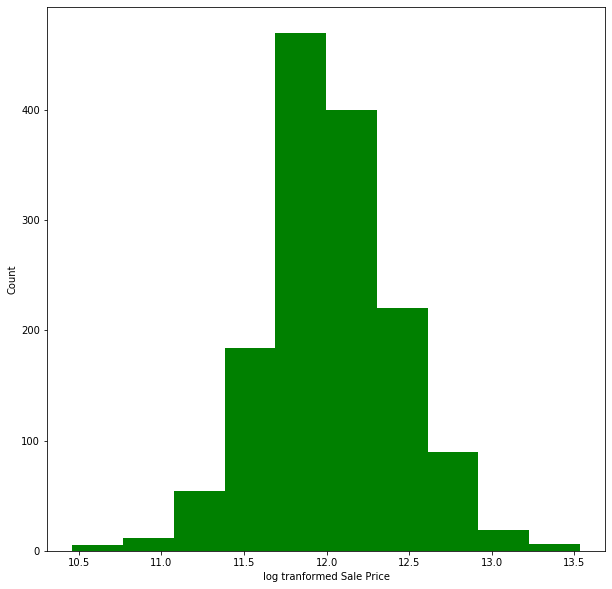

In [12]:
plt.figure(figsize = (10, 10))
plt.hist(train['LT_SalePrice'], color = 'green')
plt.xlabel("log tranformed Sale Price")
plt.ylabel("Count")
plt.show()

In [13]:
train['LT_SalePrice'].skew()

0.12134661989685329

In [0]:
def correlation_heatmap(train):
    correlation = train.corr()

    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(correlation, vmax = 1.0, center = 0.0, fmt = '.2f', square = True, linewidths = 0.5, cbar_kws = {"shrink": .70})
    plt.show();

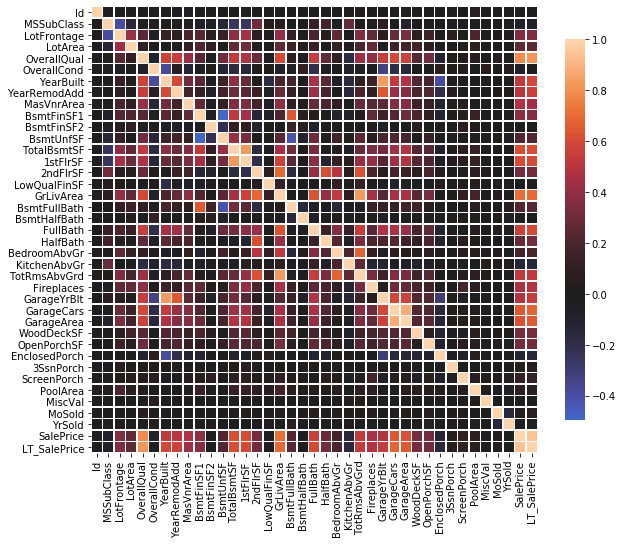

In [15]:
correlation_heatmap(train)

In [16]:
# Removing null values and NaN values
null_NaN = pd.DataFrame(train.isnull().sum().sort_values(ascending = False)[:10])
null_NaN.index.name = 'Features'
null_NaN.columns = ['Number of null or NaN values']
null_NaN

,Number of null or NaN values
Features,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageCond,81
GarageFinish,81


## **Model Selection and Model Validation**

In [34]:
# Categorical Features 
train.select_dtypes(exclude = [np.number]).columns.values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

In [0]:
categorical_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
                        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                        'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
                        'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                        'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
                        'MiscFeature', 'SaleType', 'SaleCondition']

In [36]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [0]:
data = train.select_dtypes(include = [np.number]).interpolate().dropna()

In [39]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(data)
y_noano = clf.predict(data)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

data = data.iloc[y_noano[y_noano['Top'] == 1].index.values]
data.reset_index(drop = True, inplace = True)
print('Outliers : {}'.format(y_noano[y_noano['Top'] == -1].shape[0]))
print('Normal data: {}'.format(data.shape[0]))

Outliers : 135
Normal data: 1325


In [40]:
data.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LT_SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,12.247699
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,12.109016
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,12.317171


In [0]:
from sklearn.preprocessing import MinMaxScaler

col_train = list(data.columns)
col_train_bis = list(data.columns)

In [0]:
col_train_bis.remove('SalePrice')
# col_train_bis.remove('LT_SalePrice')

In [0]:
mat_train = np.matrix(data)
# mat_test = np.matrix(test)

mat_new = np.matrix(data.drop('SalePrice', axis = 1))
mat_y = np.array(data.SalePrice).reshape((1325, 1))

In [45]:
prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_data = pd.DataFrame(prepro.transform(mat_train), columns = col_train)
# test_data = pd.DataFrame(prepro_test.transform(mat_test), columns = col_train_bis)

train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LT_SalePrice
0,0.000000,0.235294,0.150685,0.062802,0.666667,0.500,0.956204,0.883333,0.12250,0.416274,0.0,0.073457,0.396664,0.278697,0.530106,0.0,0.520424,0.333333,0.0,0.666667,0.5,0.500000,0.333333,0.6,0.000000,0.932692,0.50,0.394245,0.000000,0.116635,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.481831,0.736519
1,0.000685,0.000000,0.202055,0.072904,0.555556,0.875,0.759124,0.433333,0.00000,0.576651,0.0,0.139079,0.584801,0.495462,0.000000,0.0,0.350983,0.000000,0.5,0.666667,0.0,0.500000,0.333333,0.4,0.333333,0.673077,0.50,0.330935,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.406892,0.679374
2,0.001371,0.235294,0.160959,0.087396,0.666667,0.500,0.941606,0.866667,0.10125,0.286557,0.0,0.212537,0.426321,0.312867,0.537554,0.0,0.549168,0.333333,0.0,0.666667,0.5,0.500000,0.333333,0.4,0.333333,0.913462,0.50,0.437410,0.000000,0.080306,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.523464,0.765146
3,0.002056,0.294118,0.133562,0.072464,0.666667,0.500,0.313869,0.333333,0.00000,0.127358,0.0,0.264447,0.350324,0.334757,0.469274,0.0,0.523071,0.333333,0.0,0.333333,0.0,0.500000,0.333333,0.5,0.333333,0.884615,0.75,0.461871,0.000000,0.066922,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.291708,0.572400
4,0.002742,0.235294,0.215753,0.113835,0.777778,0.500,0.934307,0.833333,0.21875,0.386203,0.0,0.239961,0.530584,0.432995,0.653631,0.0,0.704992,0.333333,0.0,0.666667,0.5,0.666667,0.333333,0.7,0.333333,0.903846,0.75,0.601439,0.260870,0.160612,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.597016,0.811316


In [0]:
y = train.SalePrice
X = train.drop(['SalePrice', 'Id'], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.35)

In [115]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [0]:
X_train = train[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]

In [0]:
y_train = train['SalePrice']

In [118]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [0]:
X_test = test[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]

In [120]:
X_train = X_train.fillna(0)
nan_rows = X_train.iloc[np.where(X_train.isnull())]
print(nan_rows)

Empty DataFrame
Columns: []
Index: []


In [121]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,0,0,0,12,2008,WD,Normal


In [122]:
X_test = X_test.fillna(0)
nan_rows = X_test.iloc[np.where(X_test.isnull())]
print(nan_rows)

Empty DataFrame
Columns: []
Index: []


In [123]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,MnPrv,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,0,0,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,MnPrv,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,0,0,0,1,2010,WD,Normal


In [0]:
# Vectorization of numerical features
zero_feat = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']

In [0]:
from sklearn.preprocessing import StandardScaler

def numerical_vectorizations(m , o):

    scalars = StandardScaler()
    scalars.fit(m.values.reshape(-1, 1))
    print("Mean: {}, Standard deviation: {}".format(scalars.mean_[0], np.sqrt(scalars.var_[0])))

    standardized_train = scalars.transform(m.values.reshape(-1, 1))
    standardized_test = scalars.transform(o.values.reshape(-1, 1))
    return standardized_train, standardized_test


In [126]:
std_train_1, std_test_1 = numerical_vectorizations(X_train['MSSubClass'], X_test['MSSubClass'])
print(std_train_1.shape, y_train.shape)
print(std_test_1.shape)

Mean: 56.897260273972606, Standard deviation: 42.286082015480325
(1460, 1) (1460,)
(1459, 1)


In [127]:
std_train_2, std_test_2 = numerical_vectorizations(X_train['LotFrontage'], X_test['LotFrontage'])

Mean: 57.62328767123287, Standard deviation: 34.65243086038386


In [128]:
std_train_3 ,std_test_3 = numerical_vectorizations(X_train['LotArea'], X_test['LotArea'])
print('=========')
std_train_4 ,std_test_4 = numerical_vectorizations(X_train['OverallQual'], X_test['OverallQual'])
print('=========')
std_train_5 ,std_test_5 = numerical_vectorizations(X_train['OverallCond'], X_test['OverallCond'])
print('=========')
std_train_6 ,std_test_6 = numerical_vectorizations(X_train['YearBuilt'], X_test['YearBuilt'])
print('=========')
std_train_7 ,std_test_7 = numerical_vectorizations(X_train['YearRemodAdd'], X_test['YearRemodAdd'])
print('=========')
std_train_8 ,std_test_8 = numerical_vectorizations(X_train['MasVnrArea'], X_test['MasVnrArea'])
print('=========')
std_train_9 ,std_test_9 = numerical_vectorizations(X_train['BsmtFinSF1'], X_test['BsmtFinSF1'])
print('=========')
std_train_10 ,std_test_10 = numerical_vectorizations(X_train['BsmtFinSF2'], X_test['BsmtFinSF2'])
print('=========')
std_train_11 ,std_test_11 = numerical_vectorizations(X_train['BsmtUnfSF'], X_test['BsmtUnfSF'])
print('=========')
std_train_12 ,std_test_12 = numerical_vectorizations(X_train['TotalBsmtSF'], X_test['TotalBsmtSF'])
print('=========')
std_train_13 ,std_test_13 = numerical_vectorizations(X_train['1stFlrSF'], X_test['1stFlrSF'])
print('=========')
std_train_14 ,std_test_14 = numerical_vectorizations(X_train['2ndFlrSF'], X_test['2ndFlrSF'])
print('=========')
std_train_15 ,std_test_15 = numerical_vectorizations(X_train['LowQualFinSF'], X_test['LowQualFinSF'])
print('=========')
std_train_16 ,std_test_16 = numerical_vectorizations(X_train['GrLivArea'], X_test['GrLivArea'])
print('=========')
std_train_17 ,std_test_17 = numerical_vectorizations(X_train['BsmtFullBath'], X_test['BsmtFullBath'])
print('=========')
std_train_18 ,std_test_18 = numerical_vectorizations(X_train['BsmtHalfBath'],X_test['BsmtHalfBath'])
print('=========')
std_train_19 ,std_test_19 = numerical_vectorizations(X_train['FullBath'],X_test['FullBath'])
print('=========')
std_train_20 ,std_test_20 = numerical_vectorizations(X_train['HalfBath'],X_test['HalfBath'])
print('=========')
std_train_21 ,std_test_21 = numerical_vectorizations(X_train['BedroomAbvGr'],X_test['BedroomAbvGr'])
print('=========')
std_train_22 ,std_test_22 = numerical_vectorizations(X_train['KitchenAbvGr'],X_test['KitchenAbvGr'])
print('=========')
std_train_23 ,std_test_23 = numerical_vectorizations(X_train['TotRmsAbvGrd'],X_test['TotRmsAbvGrd'])
print('=========')
std_train_24 ,std_test_24 = numerical_vectorizations(X_train['Fireplaces'],X_test['Fireplaces'])
print('=========')
std_train_25 ,std_test_25 = numerical_vectorizations(X_train['GarageYrBlt'],X_test['GarageYrBlt'])
print('=========')
std_train_26 ,std_test_26 = numerical_vectorizations(X_train['GarageCars'],X_test['GarageCars'])
print('=========')
std_train_27 ,std_test_27 = numerical_vectorizations(X_train['GarageArea'],X_test['GarageArea'])
print('=========')
std_train_28 ,std_test_28 = numerical_vectorizations(X_train['WoodDeckSF'],X_test['WoodDeckSF'])
print('=========')
std_train_29 ,std_test_29 = numerical_vectorizations(X_train['OpenPorchSF'],X_test['OpenPorchSF'])
print('=========')
std_train_30 ,std_test_30 = numerical_vectorizations(X_train['EnclosedPorch'],X_test['EnclosedPorch'])
print('=========')
std_train_31 ,std_test_31 = numerical_vectorizations(X_train['3SsnPorch'],X_test['3SsnPorch'])
print('=========')
std_train_32 ,std_test_32 = numerical_vectorizations(X_train['ScreenPorch'],X_test['ScreenPorch'])
print('=========')
std_train_33 ,std_test_33 = numerical_vectorizations(X_train['PoolArea'],X_test['PoolArea'])
print('=========')
std_train_34 ,std_test_34 = numerical_vectorizations(X_train['MoSold'],X_test['MoSold'])
print('=========')
std_train_35 ,std_test_35 = numerical_vectorizations(X_train['MiscVal'],X_test['MiscVal'])
print('=========')
std_train_36 ,std_test_36 = numerical_vectorizations(X_train['YrSold'],X_test['YrSold'])

Mean: 10516.828082191782, Standard deviation: 9977.846105448105
Mean: 6.0993150684931505, Standard deviation: 1.3825228366585953
Mean: 5.575342465753424, Standard deviation: 1.1124181757710097
Mean: 1971.267808219178, Standard deviation: 30.192558810489448
Mean: 1984.8657534246574, Standard deviation: 20.63833525182198
Mean: 103.11712328767123, Standard deviation: 180.66946845020797
Mean: 443.6397260273973, Standard deviation: 455.94186610921986
Mean: 46.54931506849315, Standard deviation: 161.26401701700965
Mean: 567.2404109589041, Standard deviation: 441.71560507210364
Mean: 1057.4294520547944, Standard deviation: 438.5550571748915
Mean: 1162.626712328767, Standard deviation: 386.45532230228963
Mean: 346.99246575342465, Standard deviation: 436.3789142391623
Mean: 5.844520547945206, Standard deviation: 48.60642684100095
Mean: 1515.463698630137, Standard deviation: 525.3003935623227
Mean: 0.42534246575342466, Standard deviation: 0.5187328665380639
Mean: 0.057534246575342465, Standard d

In [129]:
# vectorization of categorical features
categorical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [0]:
for i in categorical_features:
    X_train[i] = X_train[i].replace(0, '')

for i in categorical_features:
    X_test[i] = X_test[i].replace(0, '')

for i in X_train['MSZoning']:
    if i == 'C (all)':
        X_train['MSZoning'] = X_train['MSZoning'].replace(i, 'all')

In [0]:
from collections import Counter

def categorical_vectorization(m, o):

    my_counter = Counter()
    for word in m.values:
        my_counter.update(str(word).split())
    category_dict = dict(my_counter)
    sorted_dict = dict(sorted(category_dict.items(), key = lambda kv: kv[1]))

    # convert to one hot encoder
    vectorizer = CountVectorizer(vocabulary = list(sorted_dict.keys()), lowercase = False, binary = True)
    vectorizer.fit(m.values)
    print(vectorizer.get_feature_names())

    one_hot_train = vectorizer.transform(m.values)
    one_hot_test = vectorizer.transform(o.values)
    return one_hot_train, one_hot_test

In [132]:
std_train_37 ,std_test_37 = categorical_vectorization(X_train['MSZoning'],X_test['MSZoning'])
print("After Column Standardisation: ")
print(std_train_37.shape, y_train.shape)
print(std_test_37.shape)

print('=================')

std_train_38 ,std_test_38 = categorical_vectorization(X_train['Street'],X_test['Street'])
print("After Column Standardisation: ")
print(std_train_38.shape, y_train.shape)
print(std_test_38.shape)

print('=================')

std_train_39 ,std_test_39 = categorical_vectorization(X_train['Alley'],X_test['Alley'])
print("After Column Standardisation: ")
print(std_train_39.shape, y_train.shape)
print(std_test_39.shape)

print('=================')

std_train_40 ,std_test_40 = categorical_vectorization(X_train['LotShape'],X_test['LotShape'])
print("After Column Standardisation: ")
print(std_train_40.shape, y_train.shape)
print(std_test_40.shape)

print('=================')

std_train_41 ,std_test_41 = categorical_vectorization(X_train['LandContour'],X_test['LandContour'])
print("After Column Standardisation: ")
print(std_train_41.shape, y_train.shape)
print(std_test_41.shape)

print('=================')

std_train_42 ,std_test_42 = categorical_vectorization(X_train['Utilities'],X_test['Utilities'])
print("After Column Standardisation: ")
print(std_train_42.shape, y_train.shape)
print(std_test_42.shape)

print('=================')

std_train_43 ,std_test_43 = categorical_vectorization(X_train['LotConfig'],X_test['LotConfig'])
print("After Column Standardisation: ")
print(std_train_43.shape, y_train.shape)
print(std_test_43.shape)

print('=================')

std_train_44 ,std_test_44 = categorical_vectorization(X_train['LandSlope'],X_test['LandSlope'])
print("After Column Standardisation: ")
print(std_train_44.shape, y_train.shape)
print(std_test_44.shape)

print('=================')

std_train_45 ,std_test_45 = categorical_vectorization(X_train['Neighborhood'],X_test['Neighborhood'])
print("After Column Standardisation: ")
print(std_train_45.shape, y_train.shape)
print(std_test_45.shape)

print('=================')

std_train_46 ,std_test_46 = categorical_vectorization(X_train['Condition1'],X_test['Condition1'])
print("After Column Standardisation: ")
print(std_train_46.shape, y_train.shape)
print(std_test_46.shape)

print('=================')

std_train_47 ,std_test_47 = categorical_vectorization(X_train['Condition2'],X_test['Condition2'])
print("After Column Standardisation: ")
print(std_train_47.shape, y_train.shape)
print(std_test_47.shape)

print('=================')

std_train_48 ,std_test_48 = categorical_vectorization(X_train['BldgType'],X_test['BldgType'])
print("After Column Standardisation: ")
print(std_train_48.shape, y_train.shape)
print(std_test_48.shape)

print('=================')

std_train_49 ,std_test_49 = categorical_vectorization(X_train['HouseStyle'],X_test['HouseStyle'])
print("After Column Standardisation: ")
print(std_train_49.shape, y_train.shape)
print(std_test_49.shape)

print('=================')

std_train_50 ,std_test_50 = categorical_vectorization(X_train['RoofStyle'],X_test['RoofStyle'])
print("After Column Standardisation: ")
print(std_train_50.shape, y_train.shape)
print(std_test_50.shape)

print('=================')

std_train_51 ,std_test_51 = categorical_vectorization(X_train['RoofMatl'],X_test['RoofMatl'])
print("After Column Standardisation: ")
print(std_train_51.shape, y_train.shape)
print(std_test_51.shape)

print('=================')

std_train_52 ,std_test_52 = categorical_vectorization(X_train['Exterior1st'],X_test['Exterior1st'])
print("After Column Standardisation: ")
print(std_train_52.shape, y_train.shape)
print(std_test_52.shape)

print('=================')

std_train_53 ,std_test_53 = categorical_vectorization(X_train['Exterior2nd'],X_test['Exterior2nd'])
print("After Column Standardisation: ")
print(std_train_53.shape, y_train.shape)
print(std_test_53.shape)

print('=================')

std_train_54 ,std_test_54 = categorical_vectorization(X_train['MasVnrType'],X_test['MasVnrType'])
print("After Column Standardisation: ")
print(std_train_54.shape, y_train.shape)
print(std_test_54.shape)

print('=================')

std_train_55 ,std_test_55 = categorical_vectorization(X_train['ExterQual'],X_test['ExterQual'])
print("After Column Standardisation: ")
print(std_train_55.shape, y_train.shape)
print(std_test_55.shape)

print('=================')

std_train_56 ,std_test_56 = categorical_vectorization(X_train['ExterCond'],X_test['ExterCond'])
print("After Column Standardisation: ")
print(std_train_56.shape, y_train.shape)
print(std_test_56.shape)

print('=================')

std_train_57 ,std_test_57 = categorical_vectorization(X_train['Foundation'],X_test['Foundation'])
print("After Column Standardisation: ")
print(std_train_57.shape, y_train.shape)
print(std_test_57.shape)

print('=================')

std_train_58 ,std_test_58 = categorical_vectorization(X_train['BsmtQual'],X_test['BsmtQual'])
print("After Column Standardisation: ")
print(std_train_58.shape, y_train.shape)
print(std_test_58.shape)

print('=================')

std_train_59 ,std_test_59 = categorical_vectorization(X_train['BsmtCond'],X_test['BsmtCond'])
print("After Column Standardisation: ")
print(std_train_59.shape, y_train.shape)
print(std_test_59.shape)

print('=================')

std_train_60 ,std_test_60 = categorical_vectorization(X_train['BsmtExposure'],X_test['BsmtExposure'])
print("After Column Standardisation: ")
print(std_train_60.shape, y_train.shape)
print(std_test_60.shape)

print('=================')

std_train_61 ,std_test_61 = categorical_vectorization(X_train['BsmtFinType1'],X_test['BsmtFinType1'])
print("After Column Standardisation: ")
print(std_train_61.shape, y_train.shape)
print(std_test_61.shape)

print('=================')

std_train_62 ,std_test_62 = categorical_vectorization(X_train['BsmtFinType2'],X_test['BsmtFinType2'])
print("After Column Standardisation: ")
print(std_train_62.shape, y_train.shape)
print(std_test_62.shape)

print('=================')

std_train_63 ,std_test_63 = categorical_vectorization(X_train['Heating'],X_test['Heating'])
print("After Column Standardisation: ")
print(std_train_63.shape, y_train.shape)
print(std_test_63.shape)

print('=================')

std_train_64 ,std_test_64 = categorical_vectorization(X_train['HeatingQC'],X_test['HeatingQC'])
print("After Column Standardisation: ")
print(std_train_64.shape, y_train.shape)
print(std_test_64.shape)

print('=================')

std_train_65 ,std_test_65 = categorical_vectorization(X_train['CentralAir'],X_test['CentralAir'])
print("After Column Standardisation: ")
print(std_train_65.shape, y_train.shape)
print(std_test_65.shape)

print('=================')

std_train_66 ,std_test_66 = categorical_vectorization(X_train['Electrical'],X_test['Electrical'])
print("After Column Standardisation: ")
print(std_train_66.shape, y_train.shape)
print(std_test_66.shape)

print('=================')

std_train_67 ,std_test_67 = categorical_vectorization(X_train['KitchenQual'],X_test['KitchenQual'])
print("After Column Standardisation: ")
print(std_train_67.shape, y_train.shape)
print(std_test_67.shape)

print('=================')

std_train_68 ,std_test_68 = categorical_vectorization(X_train['Functional'],X_test['Functional'])
print("After Column Standardisation: ")
print(std_train_68.shape, y_train.shape)
print(std_test_68.shape)

print('=================')

std_train_69 ,std_test_69 = categorical_vectorization(X_train['FireplaceQu'],X_test['FireplaceQu'])
print("After Column Standardisation: ")
print(std_train_69.shape, y_train.shape)
print(std_test_69.shape)

print('=================')

std_train_70 ,std_test_70 = categorical_vectorization(X_train['GarageType'],X_test['GarageType'])
print("After Column Standardisation: ")
print(std_train_70.shape, y_train.shape)
print(std_test_70.shape)

print('=================')

std_train_71 ,std_test_71 = categorical_vectorization(X_train['GarageFinish'],X_test['GarageFinish'])
print("After Column Standardisation: ")
print(std_train_71.shape, y_train.shape)
print(std_test_71.shape)

print('=================')

std_train_72 ,std_test_72 = categorical_vectorization(X_train['GarageQual'],X_test['GarageQual'])
print("After Column Standardisation: ")
print(std_train_72.shape, y_train.shape)
print(std_test_72.shape)

print('=================')

std_train_73 ,std_test_73 = categorical_vectorization(X_train['GarageCond'],X_test['GarageCond'])
print("After Column Standardisation: ")
print(std_train_73.shape, y_train.shape)
print(std_test_73.shape)

print('=================')

std_train_74 ,std_test_74 = categorical_vectorization(X_train['PavedDrive'],X_test['PavedDrive'])
print("After Column Standardisation: ")
print(std_train_74.shape, y_train.shape)
print(std_test_74.shape)

print('=================')

std_train_75 ,std_test_75 = categorical_vectorization(X_train['PoolQC'],X_test['PoolQC'])
print("After Column Standardisation: ")
print(std_train_75.shape, y_train.shape)
print(std_test_75.shape)

print('=================')

std_train_76 ,std_test_76 = categorical_vectorization(X_train['Fence'],X_test['Fence'])
print("After Column Standardisation: ")
print(std_train_76.shape, y_train.shape)
print(std_test_76.shape)

print('=================')

std_train_77 ,std_test_77 = categorical_vectorization(X_train['MiscFeature'],X_test['MiscFeature'])
print("After Column Standardisation: ")
print(std_train_77.shape, y_train.shape)
print(std_test_77.shape)

print('=================')

std_train_78 ,std_test_78 = categorical_vectorization(X_train['SaleType'],X_test['SaleType'])
print("After Column Standardisation: ")
print(std_train_78.shape, y_train.shape)
print(std_test_78.shape)

print('=================')

std_train_79 ,std_test_79 = categorical_vectorization(X_train['SaleCondition'],X_test['SaleCondition'])
print("After Column Standardisation: ")
print(std_train_79.shape, y_train.shape)
print(std_test_79.shape)

print('=================')

['all', 'RH', 'FV', 'RM', 'RL']
After Column Standardisation: 
(1460, 5) (1460,)
(1459, 5)
['Grvl', 'Pave']
After Column Standardisation: 
(1460, 2) (1460,)
(1459, 2)
['Pave', 'Grvl']
After Column Standardisation: 
(1460, 2) (1460,)
(1459, 2)
['IR3', 'IR2', 'IR1', 'Reg']
After Column Standardisation: 
(1460, 4) (1460,)
(1459, 4)
['Low', 'HLS', 'Bnk', 'Lvl']
After Column Standardisation: 
(1460, 4) (1460,)
(1459, 4)
['NoSeWa', 'AllPub']
After Column Standardisation: 
(1460, 2) (1460,)
(1459, 2)
['FR3', 'FR2', 'CulDSac', 'Corner', 'Inside']
After Column Standardisation: 
(1460, 5) (1460,)
(1459, 5)
['Sev', 'Mod', 'Gtl']
After Column Standardisation: 
(1460, 3) (1460,)
(1459, 3)
['Blueste', 'NPkVill', 'Veenker', 'BrDale', 'MeadowV', 'Blmngtn', 'StoneBr', 'SWISU', 'ClearCr', 'IDOTRR', 'Timber', 'NoRidge', 'Mitchel', 'Crawfor', 'BrkSide', 'SawyerW', 'NWAmes', 'Sawyer', 'NridgHt', 'Gilbert', 'Somerst', 'Edwards', 'OldTown', 'CollgCr', 'NAmes']
After Column Standardisation: 
(1460, 25) (1460,

In [0]:
# Stacking numerical and categorical features
from scipy.sparse import hstack

X_tr = hstack((std_train_1,std_train_2,std_train_3,std_train_4,std_train_5,std_train_6,std_train_7,
               std_train_8,std_train_9,std_train_10,std_train_11,std_train_12,std_train_13,std_train_14,
               std_train_15,std_train_16,std_train_17,std_train_18,std_train_19,std_train_20,std_train_21,
               std_train_22,std_train_23,std_train_24,std_train_25,std_train_26,std_train_27,std_train_28,
               std_train_29,std_train_30,std_train_31,std_train_32,std_train_33,std_train_34,std_train_35,
               std_train_36,std_train_37,std_train_38,std_train_39,std_train_40,std_train_41,std_train_42,
               std_train_43,std_train_44,std_train_45,std_train_46,std_train_47,std_train_48,std_train_49,
               std_train_50,std_train_51,std_train_52,std_train_53,std_train_54,std_train_55,std_train_56,
               std_train_57,std_train_58,std_train_59,std_train_60,std_train_61,std_train_62,std_train_63,
               std_train_64,std_train_65,std_train_66,std_train_67,std_train_68,std_train_69,std_train_70,
               std_train_71,std_train_72,std_train_73,std_train_74,std_train_75,std_train_76,std_train_77,
               std_train_78,std_train_79)).tocsr()

X_te = hstack((std_test_1,std_test_2,std_test_3,std_test_4,std_test_5,std_test_6,std_test_7,std_test_8,
               std_test_9,std_test_10,std_test_11,std_test_12,std_test_13,std_test_14,std_test_15,std_test_16,
               std_test_17,std_test_18,std_test_19,std_test_20,std_test_21,std_test_22,std_test_23,std_test_24,
               std_test_25,std_test_26,std_test_27,std_test_28,std_test_29,std_test_30,std_test_31,std_test_32,
               std_test_33,std_test_34,std_test_35,std_test_36,std_test_37,std_test_38,std_test_39,std_test_40,
               std_test_41,std_test_42,std_test_43,std_test_44,std_test_45,std_test_46,std_test_47,std_test_48,
               std_test_49,std_test_50,std_test_51,std_test_52,std_test_53,std_test_54,std_test_55,std_test_56,
               std_test_57,std_test_58,std_test_59,std_test_60,std_test_61,std_test_62,std_test_63,std_test_64,
               std_test_65,std_test_66,std_test_67,std_test_68,std_test_69,std_test_70,std_test_71,std_test_72,
               std_test_73,std_test_74,std_test_75,std_test_76,std_test_77,std_test_78,std_test_79)).tocsr()

In [134]:
X_tr

<1460x291 sparse matrix of type '<class 'numpy.float64'>'
	with 106053 stored elements in Compressed Sparse Row format>

In [135]:
X_te

<1459x291 sparse matrix of type '<class 'numpy.float64'>'
	with 105940 stored elements in Compressed Sparse Row format>

In [136]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape)

Final Data matrix
(1460, 291) (1460,)
(1459, 291)


## **XGBoost Regressor Model**

In [137]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
start = datetime.now()


# XGBoost model initialization
regr = xgb.XGBRegressor(silent = False, random_state = 42)
# regr = MultiOutputRegressor(regr1)

# hyperparameters tuning
parameters = {'learning_rate' : [0.001, 0.01, 0.1], 'n_estimators' : [100, 300, 500, 700], 'max_depth' : [1, 2, 3]}

# 5 fold Cross Validation
clf = GridSearchCV(regr, param_grid = parameters, scoring = 'neg_mean_squared_error',
                   cv = 5, n_jobs = -1, verbose = 1)

result = clf.fit(X_tr, y_train)

# Final Results
print("Best: %f using %s " % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with %r" % (mean, stdev, param))

print("\nTime taken: ", start - datetime.now())

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


[15:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -700818315.828041 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 700} 
-32611854386.744179 1(2040481115.321333) with {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}
-22966724761.935692 1(1710479496.277413) with {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 300}
-16439156361.427166 1(1451883466.440138) with {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 500}
-12000014081.417210 1(1261047915.954687) with {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 700}
-32437095216.215034 1(2015401445.754864) with {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}
-22558539202.170959 1(1666670193.950982) with {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 300}
-15861533382.729404 1(1382062956.940207) with {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 500}
-11305939006.197699 1(1145

In [138]:
xgb1 = xgb.XGBRegressor(max_depth = 3,learning_rate = 0.1, n_estimators = 300, nthread = -1)
xgb1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## **Deep Learning Model with Keras**

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint

In [0]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [0]:
data = pd.concat([train, test], axis=0, sort = 'False', ignore_index = True)

In [0]:
data = data[data.columns.difference(['Id'])]

In [0]:
ids = test["Id"]

In [0]:
data = data.fillna(0)

In [0]:
#Encoding categorical data
data = pd.get_dummies(data)

In [152]:

data.shape

(2919, 312)

In [153]:
data.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Alley_0,Alley_Grvl,Alley_Pave,...,PavedDrive_Y,PoolQC_0,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_0,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_0,Utilities_AllPub,Utilities_NoSeWa
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,0,2,548.0,2.0,2003.0,1710,1,1,8450,65.0,0,60,196.0,0,2,61,5,7,0,208500.0,0,8,856.0,0,2003,2003,2008,1,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,1,2,460.0,2.0,1976.0,1262,0,1,9600,80.0,0,20,0.0,0,5,0,8,6,0,181500.0,0,6,1262.0,298,1976,1976,2007,1,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,1,2,608.0,2.0,2001.0,1786,1,1,11250,68.0,0,60,162.0,0,9,42,5,7,0,223500.0,0,6,920.0,0,2001,2002,2008,1,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,1,1,642.0,3.0,1998.0,1717,0,1,9550,60.0,0,70,0.0,0,2,35,5,7,0,140000.0,0,7,756.0,0,1915,1970,2006,1,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,1,2,836.0,3.0,2000.0,2198,1,1,14260,84.0,0,60,350.0,0,12,84,5,8,0,250000.0,0,9,1145.0,192,2000,2000,2008,1,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [0]:
train = data.iloc[:1460,:] #Upto 1460 rows from first
test = data.iloc[1460:,:] # From 1461th row to last
X_train = train[train.columns.difference(['SalePrice'])].values
y_train = train[['SalePrice']].values
X_test = test[test.columns.difference(['SalePrice'])].values

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler, PowerTransformer
pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
sc_y = StandardScaler()
sc_X = StandardScaler()
y_train = sc_y.fit_transform(y_train)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [156]:
y_train.shape

(1460, 1)

In [157]:
flat_y = y_train.flatten()
flat_y.shape

(1460,)

In [0]:
from sklearn.model_selection import KFold, cross_val_score
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [159]:
import lightgbm as lgb
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, flat_y)
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=250)
# predict
lgbm_prediction_tr = gbm.predict(X_train, num_iteration=gbm.best_iteration)
lgbm_prediction_te = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Starting training...


In [0]:
train["lgb"] = lgbm_prediction_tr
test["lgb"] = lgbm_prediction_te

In [161]:
train.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Alley_0,Alley_Grvl,Alley_Pave,...,PoolQC_0,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_0,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,lgb
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,0,2,548.0,2.0,2003.0,1710,1,1,8450,65.0,0,60,196.0,0,2,61,5,7,0,208500.0,0,8,856.0,0,2003,2003,2008,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0.340004
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,1,2,460.0,2.0,1976.0,1262,0,1,9600,80.0,0,20,0.0,0,5,0,8,6,0,181500.0,0,6,1262.0,298,1976,1976,2007,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0.013012


In [0]:
y_pred = sc_y.inverse_transform(lgbm_prediction_te)

In [163]:
y_pred

array([122875.30561256, 165582.00780359, 183867.8382247 , ...,
       153277.98201903, 115933.28368396, 214947.41628231])

In [0]:
data = pd.concat([train, test],axis=0, sort='False', ignore_index = True)
data = data[data.columns.difference(['Id'])]
train = data.iloc[:1460,:]
test = data.iloc[1460:,:]
X_train = train[train.columns.difference(['SalePrice'])].values
y_train = train[['SalePrice']].values
X_test = test[test.columns.difference(['SalePrice'])].values
pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
sc_y = StandardScaler()
sc_X = StandardScaler()
y_train = sc_y.fit_transform(y_train)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [165]:

#Inıtialising the ANN
model = Sequential()
#Adding the input layer and first hidden layer
model.add(Dense(units =480, kernel_initializer='random_uniform', activation= 'tanh', 
                input_dim=X_train.shape[1]))
#Add the second hidden layer
model.add(Dense(units =480, kernel_initializer='random_uniform', activation= 'tanh'))
#Add the second hidden layer

model.add(Dense(units =10, kernel_initializer='random_uniform', activation= 'relu'))
#The output layer
model.add(Dense(units =1, kernel_initializer='random_uniform', activation= 'elu'))

In [166]:

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 480)               150240    
_________________________________________________________________
dense_2 (Dense)              (None, 480)               230880    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                4810      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 385,941
Trainable params: 385,941
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
opt = keras.optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='mean_squared_logarithmic_error', metrics=['mse'])
#Fitting the ANN to the training set
model_filepath = 'min_vl_model.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=1, save_best_only = True, mode='min' )
model.fit(X_train,y_train, validation_split=0.07, batch_size=32, nb_epoch=3000, callbacks=[checkpoint])
model.load_weights(model_filepath)

In [170]:
from keras.initializers import he_normal
from keras.layers.normalization import BatchNormalization

#Inıtialising the ANN
model = Sequential()
#Adding the input layer and first hidden layer
model.add(Dense(units =150, kernel_initializer=he_normal(seed=None), activation= 'tanh', 
                input_dim=X_train.shape[1]))



#Add the first hidden layer
model.add(Dense(units =100, kernel_initializer=he_normal(seed=None), activation= 'tanh'))
model.add(Dropout(0.2))

#Add the second hidden layer
model.add(Dense(units =80, kernel_initializer=he_normal(seed=None), activation= 'tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#Add the third hidden layer
model.add(Dense(units =50, kernel_initializer=he_normal(seed=None), activation= 'tanh'))


#Add the fourth hidden layer
model.add(Dense(units =30, kernel_initializer=he_normal(seed=None), activation= 'relu'))
model.add(BatchNormalization())

#Add the fifth hidden layer
model.add(Dense(units =10, kernel_initializer=he_normal(seed=None), activation= 'relu'))
model.add(BatchNormalization())

#The output layer
model.add(Dense(units =1, kernel_initializer=he_normal(seed=None), activation= 'elu'))

print(model.summary())



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 150)               46950     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                8080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80)                320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
___

In [171]:
#Compiling the ANN
opt = keras.optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='mean_squared_logarithmic_error', metrics=['mse'])
#Fitting the ANN to the training set
model_filepath = 'min_vl_model4.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=1, save_best_only = True, mode='min' )
history=model.fit(X_train,y_train, validation_split=0.07, batch_size=32, nb_epoch=2000, callbacks=[checkpoint])
model.load_weights(model_filepath)

Streaming output truncated to the last 5000 lines.
1357/1357 [==============================] - 0s 117us/step - loss: 7.7673e-04 - mean_squared_error: 0.1112 - val_loss: 0.0182 - val_mean_squared_error: 0.1530

Epoch 00751: val_loss did not improve from 0.00865
Epoch 752/2000
1357/1357 [==============================] - 0s 121us/step - loss: 0.0015 - mean_squared_error: 0.1197 - val_loss: 0.0180 - val_mean_squared_error: 0.1499

Epoch 00752: val_loss did not improve from 0.00865
Epoch 753/2000
1357/1357 [==============================] - 0s 121us/step - loss: 7.3579e-04 - mean_squared_error: 0.1091 - val_loss: 0.0172 - val_mean_squared_error: 0.1669

Epoch 00753: val_loss did not improve from 0.00865
Epoch 754/2000
1357/1357 [==============================] - 0s 122us/step - loss: 7.3998e-04 - mean_squared_error: 0.1197 - val_loss: 0.0177 - val_mean_squared_error: 0.1619

Epoch 00754: val_loss did not improve from 0.00865
Epoch 755/2000
1357/1357 [==============================] - 0s 1

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred = sc_y.inverse_transform(y_pred)

In [174]:
y_pred

array([[135460.94],
       [145737.97],
       [178928.48],
       ...,
       [160330.8 ],
       [133586.67],
       [190487.42]], dtype=float32)

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred["Id"] = ids

In [0]:
y_pred = y_pred.rename(columns={0: "SalePrice"})
y_pred = y_pred[["Id","SalePrice"]]
y_pred.to_csv("Submission.csv", index=False)

In [178]:
y_pred.head()

,Id,SalePrice
0,1461,135460.937500
1,1462,145737.968750
2,1463,178928.484375
3,1464,192070.656250
4,1465,146529.718750


In [179]:
from google.colab import files
files.download("Submission.csv")

MessageError: ignored